In [1]:
import pandas as pd
import tensorflow as tf
from underthesea import sent_tokenize
from underthesea import word_tokenize
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
df = pd.read_csv(r'vn_news_223_tdlfr.csv')
X = df.drop('label', axis=1)
y = df['label']

content = X['text']

In [3]:
from gensim.models import Word2Vec
pretrained_model = Word2Vec.load("pretrained_word2vec.model")

In [4]:
stopwords = ["bị", "bởi", "cả", "các", "cái", "cần", "càng", "chỉ", "chiếc", "cho", "chứ", "chưa", "chuyện", "có", "có_thể", "cứ", "của", "cùng", "cũng", "đã", "đang", "đây", "để", "đến_nỗi", "đều", "điều", "do", "đó", "được", "dưới", "gì", "khi", "không", "là", "lại", "lên", "lúc", "mà", "mỗi", "một_cách", "này", "nên", "nếu", "ngay", "nhiều", "như", "nhưng", "những", "nơi", "nữa", "phải", "qua", "ra", "rằng", "rằng", "rất", "rất", "rồi", "sau", "sẽ", "so", "sự", "tại", "theo", "thì", "trên", "trước", "từ", "từng", "và", "vẫn", "vào", "vậy", "vì", "việc", "với", "vừa"]
sent = set()
## Sentence tokenization
for i in range(0, len(content)):
    sentence = sent_tokenize(content[i])
    for s in sentence:
        sent.add(s)
sent = list(sent)

for i in range(0, len(sent)):
    sent[i] = re.sub('[\W]', ' ', sent[i].lower())
    tokens = []
    for t in word_tokenize(sent[i]):
        t = t.replace(" ", "_")
        if t not in stopwords:
            tokens.append(t)
    sent[i] = tokens


In [5]:
pretrained_model.build_vocab(sent, update=True)  # Cập nhật từ vựng
pretrained_model.train(
    sent,                                          # Dữ liệu mới
    total_examples=pretrained_model.corpus_count,  # Số câu
    epochs=pretrained_model.epochs  # Số vòng lặp
)

(665250, 729750)

In [6]:
for i in range(len(content)):
    tokenized_word = [word for word in word_tokenize(content[i].lower()) if word not in stopwords]
    for j in range(len(tokenized_word)):
        tokenized_word[j] = tokenized_word[j].replace(" ", "_")
    content[i] = " ".join(tokenized_word)


In [ ]:
# Khởi tạo Tokenizer và tạo từ điển
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',
    lower=True,
    split=' ')
tokenizer.fit_on_texts(content)

# Chuyển văn bản thành chuỗi số
sequences = tokenizer.texts_to_sequences(content)

In [8]:
import numpy as np
nos = np.array([len(c) for c in content])
len(nos[nos  < 4000])

194

In [9]:
### Find max news length
max_length = 4000
'''sent = []
for i in range(len(content)):
        if len(content[i]) > max_length:
            max_length = len(content[i])'''

max_length

padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

In [10]:
import numpy as np

embedding_dim = pretrained_model.vector_size  # Kích thước vector từ trong Word2Vec
vocab_size = len(tokenizer.word_index) + 1  # Số lượng từ trong từ điển (+1 để cho từ padding)

# Khởi tạo ma trận nhúng
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Lấp đầy ma trận nhúng
for word, i in tokenizer.word_index.items():
    if word in pretrained_model.wv:
        embedding_matrix[i] = pretrained_model.wv[word]  # Gán vector nhúng của từ vào
    else:
        embedding_matrix[i] = np.random.uniform(-0.01, 0.01, embedding_dim)  # Vector ngẫu nhiên cho từ không tìm thấy

print("Kích thước ma trận nhúng:", embedding_matrix.shape)


Kích thước ma trận nhúng: (9644, 300)


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, GlobalMaxPooling1D, Attention
from tensorflow.keras.optimizers import Adam

model = Sequential()

    # Embedding Layer
model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=False  # Keep embeddings non-trainable to preserve semantic knowledge
    ))

    # Bidirectional LSTM
model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)))

    # Attention Mechanism
model.add(GlobalMaxPooling1D())  # Alternative to adding a custom attention layer

    # Dense Layers with Dropout
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

    # Output Layer
model.add(Dense(2, activation='softmax'))  # For binary classification

    # Compile the Model
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

Epoch 1/10
6/6 [==============================] - 281s 48s/step - loss: 0.7949 - accuracy: 0.5787 - val_loss: 0.7082 - val_accuracy: 0.4000
Epoch 2/10
6/6 [==============================] - 271s 46s/step - loss: 0.7762 - accuracy: 0.5112 - val_loss: 0.6637 - val_accuracy: 0.4889
Epoch 3/10
6/6 [==============================] - 288s 49s/step - loss: 0.7086 - accuracy: 0.6236 - val_loss: 0.5590 - val_accuracy: 0.9111
Epoch 4/10
6/6 [==============================] - 303s 52s/step - loss: 0.6729 - accuracy: 0.6910 - val_loss: 0.5214 - val_accuracy: 0.8222
Epoch 5/10
6/6 [==============================] - 307s 52s/step - loss: 0.6237 - accuracy: 0.7135 - val_loss: 0.3631 - val_accuracy: 0.9333
Epoch 6/10
6/6 [==============================] - 319s 55s/step - loss: 0.5017 - accuracy: 0.8034 - val_loss: 0.2840 - val_accuracy: 0.9111
Epoch 7/10
6/6 [==============================] - 344s 57s/step - loss: 0.4735 - accuracy: 0.8371 - val_loss: 0.2839 - val_accuracy: 0.9111
Epoch 8/10
6/6 [====

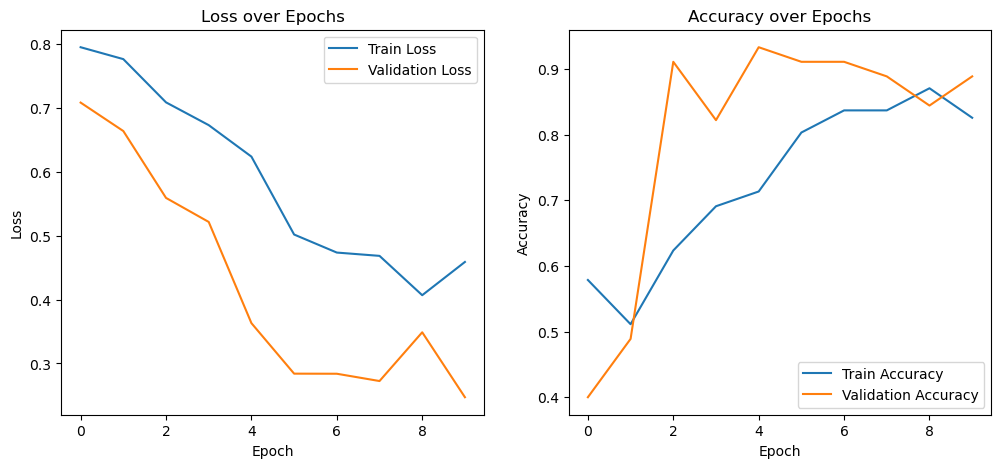

In [12]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

# One-hot encode labels
y = to_categorical(y, num_classes=2)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, y, test_size=0.2, random_state=42
)

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_test, y_test), 
    epochs=10,  # Number of epochs
    batch_size=32,  # Batch size
    callbacks=[early_stopping], 
    verbose=1,
    class_weight={0: 1.0, 1: 123 / 100}  # Adjust class weights if needed
)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Loss on test set: {loss:.4f}")
print(f"Accuracy on test set: {accuracy:.4f}")

# Plot loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

2/2 [==============================] - 16s 7s/step
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.89      0.93      0.91        27
     Class 1       0.88      0.83      0.86        18

    accuracy                           0.89        45
   macro avg       0.89      0.88      0.88        45
weighted avg       0.89      0.89      0.89        45



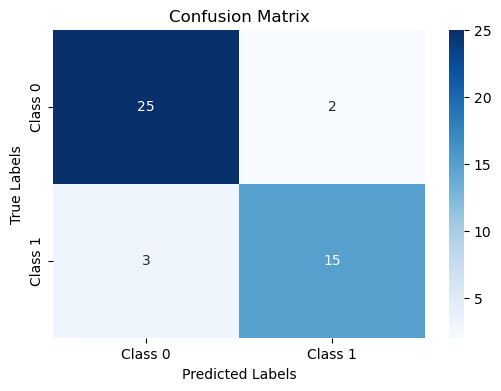

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Dự đoán trên tập kiểm tra
y_pred_prob = model.predict(X_test)  # Dự đoán xác suất
y_pred = np.argmax(y_pred_prob, axis=1)  # Chuyển xác suất thành nhãn (0 hoặc 1)
y_true = np.argmax(y_test, axis=1)  # Chuyển nhãn thực tế từ one-hot encoding

# In classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Class 0", "Class 1"]))

# Tạo Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Vẽ confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
